## Preprocessing and data augmentation

In [ ]:
import os
import sys
import csv
import cv2
import time
import torch
import random
import shutil
import argparse
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split

def is_uppercase(stem):
    """
    Returns True if the filename stem starts with an uppercase letter,
    which we use to mean it's a cat image.
    """
    if not stem:
        return False
    return stem[0].isupper()

def colorize_label(label_img, include_boundary=False):
    """
    Converts a numeric mask (PIL Image in 'L') into an RGB image.
    For include_boundary==False, the expected classes are:
      0: background -> black
      1: cat       -> orange
      2: dog       -> cyan
    For include_boundary==True, we expect an additional class:
      3: boundary  -> white
    """
    arr = np.array(label_img)
    color_arr = np.zeros((arr.shape[0], arr.shape[1], 3), dtype=np.uint8)
    if include_boundary:
        color_map = {
            0: (0,   0,   0),      # background = black
            1: (255, 165, 0),      # cat = orange
            2: (0,   255, 255),    # dog = cyan
            3: (255, 255, 255)     # boundary = white
        }
    else:
        color_map = {
            0: (0, 0, 0),
            1: (255, 165, 0),
            2: (0, 255, 255)
        }
    for class_val, color in color_map.items():
        color_arr[arr == class_val] = color
    return Image.fromarray(color_arr, mode="RGB")

def convert_label_to_three_classes(label_img, is_cat):
    """
    For TrainVal:
    Convert a grayscale label (mode "L") that may contain:
      - 0 for background,
      - 255 for boundary,
      - values in (1..254) for the animal region,
    into a new label with:
      - 0 for background (and boundary merged),
      - 1 for cat (if is_cat True),
      - 2 for dog (if is_cat False).
    """
    arr = np.array(label_img, dtype=np.uint8)
    new_label = np.zeros_like(arr, dtype=np.uint8)
    if is_cat:
        new_label[(arr > 0) & (arr < 255)] = 1
    else:
        new_label[(arr > 0) & (arr < 255)] = 2
    return Image.fromarray(new_label)

def convert_label_test(label_img, is_cat):
    """
    For Test:
    Convert an RGB label image (that contains a boundary) into a numeric mask with 4 classes:
      0 = background (black)
      3 = boundary (white; pixels where R=G=B=255)
      For the remaining animal region, assign:
          1 if is_cat is True (cat),
          2 if is_cat is False (dog).
    """
    arr = np.array(label_img)
    # Create a single-channel mask
    mask = np.zeros(arr.shape[:2], dtype=np.uint8)
    # Background: where pixel is black
    background = (arr[:,:,0] == 0) & (arr[:,:,1] == 0) & (arr[:,:,2] == 0)
    mask[background] = 0
    # Boundary: where pixel is white
    boundary = (arr[:,:,0] == 255) & (arr[:,:,1] == 255) & (arr[:,:,2] == 255)
    mask[boundary] = 3
    # Animal region: everything that is not background or boundary
    animal = ~(background | boundary)
    if is_cat:
        mask[animal] = 1
    else:
        mask[animal] = 2
    return Image.fromarray(mask)

# --------------------------
# Resizing and Padding Classes
# --------------------------

class ResizeWithPadding:
    """For color images. Uses bilinear interpolation."""
    def __init__(self, target_size=512, padding_mode='mean', force_resize=True, resize_dims=(128, 128)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims
        assert padding_mode in ['mean', 'reflect', 'hybrid'], "Padding mode must be 'mean', 'reflect', or 'hybrid'"
        self.padding_mode = padding_mode

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    def pad_image(self, image):
        h, w = image.shape[:2]
        target_h, target_w = (self.resize_dims if self.force_resize else (self.target_size, self.target_size))
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        if self.padding_mode == 'mean':
            mean_pixel = np.mean(image, axis=(0,1), dtype=int)
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        elif self.padding_mode == 'reflect':
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
        else:
            reflected = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
            mean_pixel = np.mean(image, axis=(0,1), dtype=int)
            padded_image = cv2.copyMakeBorder(reflected, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        return padded_image

    def __call__(self, img):
        arr = np.array(img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

class ResizeWithPaddingLabel:
    """For label images. Uses nearest-neighbor interpolation."""
    def __init__(self, target_size=512, force_resize=False, resize_dims=(256, 256)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w*scale), int(h*scale)
        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    def pad_image(self, image):
        h, w = image.shape[:2]
        target_h, target_w = (self.resize_dims if self.force_resize else (self.target_size, self.target_size))
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    def __call__(self, label_img):
        arr = np.array(label_img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

# --------------------------
# Augmentation Function for Synchronized Transforms
# --------------------------

def elastic_transform_pair(image, label, alpha=34, sigma=4):
    """Apply elastic transformation to both image and label."""
    np_img = np.array(image)
    np_label = np.array(label)
    random_state = np.random.RandomState(None)
    shape = np_img.shape[:2]
    dx = (random_state.rand(*shape) * 2 - 1)
    dy = (random_state.rand(*shape) * 2 - 1)
    dx = cv2.GaussianBlur(dx, (17,17), sigma) * alpha
    dy = cv2.GaussianBlur(dy, (17,17), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x+dx).astype(np.float32)
    map_y = (y+dy).astype(np.float32)
    transformed_img = cv2.remap(np_img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    transformed_label = cv2.remap(np_label, map_x, map_y, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    return Image.fromarray(transformed_img), Image.fromarray(transformed_label)

def augment_pair(image, label, size=(256,256), apply_color=True, **params):
    """
    Applies a random subset of augmentations in random order.
    """
    augmentations = []
    augmentations.append((lambda img, lbl: (F.hflip(img), F.hflip(lbl)), params.get("flip_prob",0.5)))
    def rotate_aug(img, lbl):
        angle = random.uniform(-params.get("rotation_angle",5), params.get("rotation_angle",45))
        return F.rotate(img, angle, interpolation=Image.BILINEAR), F.rotate(lbl, angle, interpolation=Image.NEAREST)
    augmentations.append((rotate_aug, params.get("rotation_prob",0.25)))
    def translate_aug(img, lbl):
        max_translate = params.get("translate_factor", 0.05)*size[0]
        tx = int(random.uniform(-max_translate, max_translate))
        ty = int(random.uniform(-max_translate, max_translate))
        return (F.affine(img, angle=0, translate=(tx,ty), scale=1.0, shear=0, interpolation=Image.BILINEAR),
                F.affine(lbl, angle=0, translate=(tx,ty), scale=1.0, shear=0, interpolation=Image.NEAREST))
    augmentations.append((translate_aug, params.get("translate_prob",0.05)))
    def crop_aug(img, lbl):
        i,j,h,w = transforms.RandomResizedCrop.get_params(img, scale=params.get("crop_scale_range",(0.9,1.0)), ratio=params.get("crop_ratio_range",(1.0,1.0)))
        return (F.resized_crop(img, i,j,h,w,size, interpolation=Image.BILINEAR),
                F.resized_crop(lbl, i,j,h,w,size, interpolation=Image.NEAREST))
    augmentations.append((crop_aug, params.get("crop_prob",0.01)))
    def elastic_aug(img, lbl):
        return elastic_transform_pair(img, lbl, alpha=params.get("elastic_alpha",15), sigma=params.get("elastic_sigma",2))
    augmentations.append((elastic_aug, params.get("elastic_prob",0.01)))
    def scaling_aug(img, lbl):
        scale_factor = random.uniform(*params.get("scaling_range",(0.0,0.0)))
        new_size = (int(size[0]*scale_factor), int(size[1]*scale_factor))
        return (F.resize(img, new_size, interpolation=Image.BILINEAR),
                F.resize(lbl, new_size, interpolation=Image.NEAREST))
    augmentations.append((scaling_aug, params.get("scaling_prob",0.0)))
    def color_aug(img, lbl):
        if random.random() < params.get("blur_prob",0.0):
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(*params.get("blur_radius_range",(0.5,1.5)))))
        color_jitter = transforms.ColorJitter(**params.get("color_jitter_params",{'brightness':0.2,'contrast':0.2,'saturation':0.2,'hue':0.1}))
        img = color_jitter(img)
        return img, lbl
    augmentations.append((color_aug, params.get("color_prob",0.25)))
    random.shuffle(augmentations)
    for func, prob in augmentations:
        if random.random() < prob:
            image, label = func(image, label)
    image = F.center_crop(image, size)
    label = F.center_crop(label, size)
    return image, label

# --------------------------
# OOP Preprocessor Class
# --------------------------

class Preprocessor:
    def __init__(self, raw_color_path, raw_label_path,
                 proc_color_path, proc_label_path,
                 resize_dim=128, do_augmentation=True,
                 is_train=True, max_images=None, aug_count=10, aug_params=None):
        self.aug_params = aug_params if aug_params is not None else {}
        self.raw_color_path = Path(raw_color_path)
        self.raw_label_path = Path(raw_label_path)
        self.proc_color_path = Path(proc_color_path)
        self.proc_label_path = Path(proc_label_path)
        self.resize_dim = resize_dim
        self.do_augmentation = do_augmentation and is_train
        self.is_train = is_train  # True for TrainVal, False for Test
        self.max_images = max_images
        self.aug_count = aug_count
        self.proc_color_path.mkdir(parents=True, exist_ok=True)
        self.proc_label_path.mkdir(parents=True, exist_ok=True)
        self.transform_img = ResizeWithPadding(target_size=224, padding_mode='mean',
                                              force_resize=True, resize_dims=(resize_dim, resize_dim))
        self.transform_label = ResizeWithPaddingLabel(target_size=224, force_resize=True,
                                                      resize_dims=(resize_dim, resize_dim))

    def process(self):
        image_extensions = (".jpg", ".jpeg", ".png")
        image_files = [f for f in self.raw_color_path.rglob("*") if f.suffix.lower() in image_extensions]
        if self.max_images is not None:
            image_files = image_files[:self.max_images]
        if not image_files:
            print("❌ No images found in", self.raw_color_path)
            return
        for img_file in image_files:
            label_file = self.raw_label_path / f"{img_file.stem}.png"
            if not label_file.exists():
                print(f"⚠️  Label for {img_file.name} not found, skipping.")
                continue

            # For TrainVal, load label in grayscale; for Test, load in RGB (to preserve boundaries)
            if self.is_train:
                label = Image.open(label_file).convert("L")
            else:
                label = Image.open(label_file).convert("RGB")
            img = Image.open(img_file).convert("RGB")
            proc_img = self.transform_img(img)
            proc_label = self.transform_label(label)
            cat_or_dog = is_uppercase(img_file.stem)  # True => cat, False => dog

            if self.is_train:
                # Merge boundary with background and set animal region accordingly.
                numeric_label = convert_label_to_three_classes(proc_label, cat_or_dog)
                colorized_label = colorize_label(numeric_label)
            else:
                # Test: Convert RGB label to numeric with boundary preserved (0,1,2,3),
                # then colorize using the same mapping (cat always orange, dog always cyan, boundary white).
                numeric_label = convert_label_test(proc_label, cat_or_dog)
                colorized_label = colorize_label(numeric_label, include_boundary=True)

            if cat_or_dog:
                proc_img.save(self.proc_color_path / f"cat_{img_file.name}")
                colorized_label.save(self.proc_label_path / f"cat_{label_file.name}")
                print(f"Processed (cat) {img_file.name}")
            else:
                proc_img.save(self.proc_color_path / f"dog_{img_file.name}")
                colorized_label.save(self.proc_label_path / f"dog_{label_file.name}")
                print(f"Processed (dog) {img_file.name}")

            if self.is_train and self.do_augmentation:
                for i in range(self.aug_count):
                    aug_img, aug_label = augment_pair(proc_img, numeric_label,
                                                      size=(self.resize_dim, self.resize_dim),
                                                      **self.aug_params)
                    colorized_aug_label = colorize_label(aug_label)
                    if cat_or_dog:
                        aug_img.save(self.proc_color_path / f"cat_{img_file.stem}_aug_{i}{img_file.suffix}")
                        colorized_aug_label.save(self.proc_label_path / f"cat_{label_file.stem}_aug_{i}{label_file.suffix}")
                    else:
                        aug_img.save(self.proc_color_path / f"dog_{img_file.stem}_aug_{i}{img_file.suffix}")
                        colorized_aug_label.save(self.proc_label_path / f"dog_{label_file.stem}_aug_{i}{label_file.suffix}")
                    print(f"Augmented {img_file.name} -> aug {i}")

# --------------------------
# Command Line Interface
# --------------------------

if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Preprocess train/test images with labels/masks using relative paths."
    )
    parser.add_argument("--raw_color", type=str, required=True, default='raw/TrainVal/color')
    parser.add_argument("--raw_label", type=str, required=True, default='raw/TrainVal/label')
    parser.add_argument("--proc_color", type=str, required=True, default='Dataset/processed/TrainVal/color')
    parser.add_argument("--proc_label", type=str, required=True, default='Dataset/processed/TrainVal/label')
    parser.add_argument("--resize_dim", type=int, default=128)
    parser.add_argument("--no_augment", action="store_true")
    parser.add_argument("--max_images", type=int, default=None)
    parser.add_argument("--aug_count", type=int, default=10)
    parser.add_argument("--set_type", type=str, choices=["TrainVal", "Test"], default="TrainVal")
    parser.add_argument("--flip_prob", type=float, default=0.5)
    parser.add_argument("--rotation_angle", type=float, default=5)
    parser.add_argument("--translate_factor", type=float, default=0.05)
    parser.add_argument("--crop_scale_min", type=float, default=0.9)
    parser.add_argument("--crop_scale_max", type=float, default=1.0)
    parser.add_argument("--crop_ratio_min", type=float, default=1.0)
    parser.add_argument("--crop_ratio_max", type=float, default=1.0)
    parser.add_argument("--elastic_alpha", type=float, default=15)
    parser.add_argument("--elastic_sigma", type=float, default=2)
    parser.add_argument("--scaling_min", type=float, default=0.0)
    parser.add_argument("--scaling_max", type=float, default=0.0)
    parser.add_argument("--blur_prob", type=float, default=0.3)
    parser.add_argument("--blur_radius_min", type=float, default=0.5)
    parser.add_argument("--blur_radius_max", type=float, default=1.5)
    parser.add_argument("--color_jitter_brightness", type=float, default=0.2)
    parser.add_argument("--color_jitter_contrast", type=float, default=0.2)
    parser.add_argument("--color_jitter_saturation", type=float, default=0.2)
    parser.add_argument("--color_jitter_hue", type=float, default=0.1)

    # Example invocation (change as needed)
    sys.argv = [
        'preprocessing.py',
        '--raw_color', './Datasetraw/Test/color',
        '--raw_label', './Dataset/raw/Test/label',
        '--proc_color', './Dataset/processed/Test/color',
        '--proc_label', './Dataset/processed/Test/label',
        '--resize_dim', '128',
        '--no_augment',
        '--set_type', 'Test'
    ]

    sys.argv = ['preprocessing.py',
                '--raw_color', './Dataset/raw/TrainVal/color',
                '--raw_label', './Dataset/raw/TrainVal/label',
                '--proc_color', './Dataset/processed/TrainVal/color',
                '--proc_label', './Dataset/processed/TrainVal/label',
                '--resize_dim', '128',
                '--aug_count', '10',
                '--set_type', 'TrainVal',
                '--translate_factor', '0.02',
                '--elastic_alpha', '0.0',
                '--elastic_sigma', '0.05',
                '--blur_radius_min', '0.0',
                '--blur_radius_max', '0.05']

    args = parser.parse_args()

    if args.set_type == "TrainVal":
        raw_color = Path("./raw/TrainVal/color")
        raw_label = Path("./raw/TrainVal/label")
        proc_color = Path("./Dataset/processed/TrainVal/color")
        proc_label = Path("./Dataset/processed/TrainVal/label")
        is_train = True
    else:
        raw_color = Path("./raw/Test/color")
        raw_label = Path("./raw/Test/label")
        proc_color = Path("./Dataset/processed/Test/color")
        proc_label = Path("./Dataset/processed/Test/label")
        is_train = False

    aug_params = {
        "flip_prob": args.flip_prob,
        "rotation_angle": args.rotation_angle,
        "rotation_prob": 0.25,
        "translate_factor": args.translate_factor,
        "translate_prob": 0.05,
        "crop_scale_range": (args.crop_scale_min, args.crop_scale_max),
        "crop_ratio_range": (args.crop_ratio_min, args.crop_ratio_max),
        "crop_prob": 0.01,
        "elastic_alpha": args.elastic_alpha,
        "elastic_sigma": args.elastic_sigma,
        "elastic_prob": 0.01,
        "scaling_range": (0.8, 1.2),
        "scaling_prob": 0.05,
        "blur_prob": args.blur_prob,
        "blur_radius_range": (args.blur_radius_min, args.blur_radius_max),
        "color_jitter_params": {
            "brightness": args.color_jitter_brightness,
            "contrast": args.color_jitter_contrast,
            "saturation": args.color_jitter_saturation,
            "hue": args.color_jitter_hue,
        },
        "color_prob": 1.0
    }

    preprocessor = Preprocessor(
        raw_color, raw_label,
        proc_color, proc_label,
        resize_dim=args.resize_dim,
        do_augmentation=not args.no_augment,
        is_train=is_train,
        max_images=args.max_images,
        aug_count=args.aug_count,
        aug_params=aug_params
    )

    preprocessor.process()

Processed and Renamed Egyptian_Mau_167.jpg → cat_Egyptian_Mau_167.jpg
Processed and Renamed pug_52.jpg → dog_pug_52.jpg
Processed and Renamed Siamese_53.jpg → cat_Siamese_53.jpg
Processed and Renamed leonberger_6.jpg → dog_leonberger_6.jpg
Processed and Renamed Siamese_47.jpg → cat_Siamese_47.jpg
Processed and Renamed Abyssinian_225.jpg → cat_Abyssinian_225.jpg
Processed and Renamed miniature_pinscher_200.jpg → dog_miniature_pinscher_200.jpg
Processed and Renamed wheaten_terrier_49.jpg → dog_wheaten_terrier_49.jpg
Processed and Renamed pug_46.jpg → dog_pug_46.jpg
Processed and Renamed shiba_inu_43.jpg → dog_shiba_inu_43.jpg
Processed and Renamed wheaten_terrier_61.jpg → dog_wheaten_terrier_61.jpg
Processed and Renamed saint_bernard_2.jpg → dog_saint_bernard_2.jpg
Processed and Renamed Abyssinian_219.jpg → cat_Abyssinian_219.jpg
Processed and Renamed shiba_inu_57.jpg → dog_shiba_inu_57.jpg
Processed and Renamed wheaten_terrier_75.jpg → dog_wheaten_terrier_75.jpg
Processed and Renamed pu

## Installation of CLIP

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

## Preprocessing data

In [ ]:
import os
import re
import clip
import time
import csv
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from clip.simple_tokenizer import SimpleTokenizer

clip_tokenizer = SimpleTokenizer()

class SegmentationDatasetWithText(Dataset):
    """
    Dataset for segmentation with text prompts.
    
    Assumes:
      - Images are in root_dir/color.
      - Masks are in root_dir/label.
      - Each mask is a color-coded image where:
          • Background: Black [0,0,0] → 0
          • Cat: Orange [255,165,0] → 1
          • Dog: Cyan [0,255,255] → 2
      - A text prompt is generated from the filename, e.g.:
            "cat_Siamese_27.png" → "a photo of a Siamese cat"
    """
    def __init__(self, root_dir, transform_img, transform_label=None):
        self.root_dir = root_dir
        self.transform_img = transform_img
        self.transform_label = transform_label
        
        self.image_dir = os.path.join(root_dir, 'color')
        self.mask_dir = os.path.join(root_dir, 'label')
        
        self.image_paths = sorted([
            fname for fname in os.listdir(self.image_dir)
            if fname.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_filename = self.image_paths[index]
        image_path = os.path.join(self.image_dir, image_filename)
        # Use the same stem and force a .png extension for the mask.
        mask_path = os.path.join(self.mask_dir, Path(image_filename).stem + ".png")
        
        # Load and transform the image.
        image = Image.open(image_path).convert("RGB")
        if self.transform_img:
            image = self.transform_img(image)
        
        # Load the mask as RGB and map colors to class indices.
        mask_img = Image.open(mask_path).convert("RGB")
        mask_np = np.array(mask_img, dtype=np.uint8)
        label_new = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.int64)
        
        # Map background: black → 0.
        background_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 0) & (mask_np[..., 2] == 0)
        label_new[background_mask] = 0
        
        # Map cat: orange [255,165,0] → 1.
        cat_mask = (mask_np[..., 0] == 255) & (mask_np[..., 1] == 165) & (mask_np[..., 2] == 0)
        label_new[cat_mask] = 1
        
        # Map dog: cyan [0,255,255] → 2.
        dog_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 255) & (mask_np[..., 2] == 255)
        label_new[dog_mask] = 2
        
        mask = torch.from_numpy(label_new).long()
        if self.transform_label:
            if mask.ndim == 2:
                mask = mask.unsqueeze(0)
            mask = self.transform_label(mask)
            mask = mask.squeeze(0)
        
        # Generate text prompt based on filename.
        name, _ = os.path.splitext(image_filename)
        match = re.match(r"^(cat|dog)_([A-Za-z_]+)_(\d+)", name)
        if match:
            animal_type = match.group(1)  # "cat" or "dog"
            breed = match.group(2).replace("_", " ")
            breed = breed.title()
            text_prompt = f"a photo of a {breed} {animal_type}"
        else:
            text_prompt = "a photo of an animal"
        
        token_ids = clip.tokenize([text_prompt]).squeeze(0)
        
        # (Optional) Decode the tokens for debugging.
        decoded_text = clip_tokenizer.decode(token_ids.tolist())
        # print(f"Original: {text_prompt} → Tokenized: {decoded_text}")
        
        return image, mask, token_ids

## CLIP features model architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class ImprovedCLIPSegmentationHead(nn.Module):
    def __init__(self, in_channels, text_dim, num_classes, dropout_prob=0.25, use_attention=True):
        super(ImprovedCLIPSegmentationHead, self).__init__()
        # Project text features to match visual feature channels.
        self.text_proj = nn.Linear(text_dim, in_channels)
        self.fuse_conv1 = nn.Sequential(
            nn.Conv2d(in_channels * 2, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob)
        )
        self.residual_block = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
        )
        self.relu = nn.ReLU(inplace=True)
        self.attention = ChannelAttention(256) if use_attention else nn.Identity()
        self.fuse_conv2 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, img_features, text_features):
        B, C, H, W = img_features.shape  # Expected C = 768
        img_features = img_features.float()
        text_features = text_features.float()

        projected_text = self.text_proj(text_features)  # [B, 768]
        projected_text = projected_text.view(B, C, 1, 1).expand(B, C, H, W)
        fused = torch.cat([img_features, projected_text], dim=1)
        x = self.fuse_conv1(fused)
        res = self.residual_block(x)
        x = self.relu(x + res)
        x = self.attention(x)
        logits = self.fuse_conv2(x)
        return logits

class CLIPSegmentationModel(nn.Module):
    def __init__(self, clip_model, num_classes=3):
        super(CLIPSegmentationModel, self).__init__()
        # Get feature dimension from the CLIP visual model (e.g., 768).
        self.feature_dim = clip_model.visual.output_dim
        print(f'Feature dimension: {self.feature_dim}')  # Expected 768
        
        self.clip_model = clip_model
        # Segmentation head with input channels and text dimension matching CLIP.
        self.seg_head = ImprovedCLIPSegmentationHead(
            in_channels=self.feature_dim,
            text_dim=self.feature_dim,
            num_classes=num_classes,
            dropout_prob=0.25
        )
    
    def get_visual_features(self, image):
        visual = self.clip_model.visual
        image = image.to(dtype=visual.conv1.weight.dtype)
        x = visual.conv1(image)  # [B, width, H', W']
        x = x.reshape(x.shape[0], x.shape[1], -1).permute(0, 2, 1)  # [B, tokens, width]
        cls_tokens = visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + visual.positional_embedding.to(x.dtype)
        x = visual.ln_pre(x)
        x = x.permute(1, 0, 2)
        x = visual.transformer(x)
        x = x.permute(1, 0, 2)
        if hasattr(visual, "proj"):
            x = x @ visual.proj
        return x

    def forward(self, image, token_ids):
      image = image.float()
      # Compute CLIP features without tracking gradients.
      with torch.no_grad():
          visual_features = self.get_visual_features(image)  # [B, num_tokens+1, 768]
          tokens = visual_features[:, 1:, :]  # remove the class token
          B, N, D = tokens.shape
          grid_size = int(np.sqrt(N))
          image_features = tokens.reshape(B, grid_size, grid_size, D).permute(0, 3, 1, 2)
          text_features = self.clip_model.encode_text(token_ids).float()
          
      # Compute segmentation head normally (gradients tracked here).
      seg_logits = self.seg_head(image_features, text_features)
      seg_logits = F.interpolate(seg_logits, size=(image.shape[2], image.shape[3]),
                                mode="bilinear", align_corners=False)
      return seg_logits

## Training function

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import csv
import time
import random
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# (Assume other required imports and your dataset/model classes are defined above.)

###############################################
#        Metric Helper Functions              #
###############################################

def compute_iou(preds, targets, num_classes=3, smooth=1e-6):
    """
    Computes IoU for each class.
    Both preds and targets are torch tensors of shape [N, H, W].
    Returns a list of IoU values for each class.
    """
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection + smooth) / (union + smooth))
    return ious

def compute_dice(preds, targets, num_classes=3, smooth=1e-6):
    """
    Computes the Dice coefficient for each class.
    preds and targets are torch tensors of shape [N, H, W].
    Returns:
      - avg_dice: the average Dice score (ignoring NaNs)
      - dice_tensor: a tensor with the Dice score per class.
    """
    dice_scores = []
    for cls in range(num_classes):
        pred_c = (preds == cls).float()
        target_c = (targets == cls).float()
        intersection = (pred_c * target_c).sum().float()
        union = pred_c.sum() + target_c.sum()
        if union == 0:
            dice_scores.append(float('nan'))
        else:
            dice_scores.append((2 * intersection + smooth) / (union + smooth))
    dice_tensor = torch.tensor(dice_scores, dtype=torch.float32)
    avg_dice = torch.nanmean(dice_tensor).item()
    return avg_dice, dice_tensor

def pixel_accuracy(output, target):
    """
    Computes pixel accuracy given the model output and target.
    output: logits tensor of shape [N, C, H, W]
    target: ground truth tensor of shape [N, H, W]
    """
    _, preds = torch.max(output, dim=1)
    correct = (preds == target).float().sum().item()
    return correct / torch.numel(target)

###############################################
#           Save Metrics to CSV               #
###############################################

def save_metrics(metrics, test_loss, test_acc, test_iou, test_dice, filepath):
    fieldnames = [
        'epoch', 'train_loss', 'train_acc', 
        'val_loss', 'val_acc', 
        'val_iou_avg', 'val_iou_class0', 'val_iou_class1', 'val_iou_class2',
        'val_dice_avg', 'val_dice_class0', 'val_dice_class1', 'val_dice_class2',
        'test_loss', 'test_acc', 'test_iou', 'test_dice_avg'
    ]
    with open(filepath, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for m in metrics:
            writer.writerow({
                'epoch': m.get('epoch', ''),
                'train_loss': m.get('train_loss', ''),
                'train_acc': m.get('train_acc', ''),
                'val_loss': m.get('val_loss', ''),
                'val_acc': m.get('val_acc', ''),
                'val_iou_avg': m.get('val_iou_avg', ''),
                'val_iou_class0': m.get('val_iou_class0', ''),
                'val_iou_class1': m.get('val_iou_class1', ''),
                'val_iou_class2': m.get('val_iou_class2', ''),
                'val_dice_avg': m.get('val_dice_avg', ''),
                'val_dice_class0': m.get('val_dice_class0', ''),
                'val_dice_class1': m.get('val_dice_class1', ''),
                'val_dice_class2': m.get('val_dice_class2', ''),
                'test_loss': '',
                'test_acc': '',
                'test_iou': '',
                'test_dice_avg': ''
            })
        writer.writerow({
            'epoch': 'test',
            'train_loss': '',
            'train_acc': '',
            'val_loss': '',
            'val_acc': '',
            'val_iou_avg': '',
            'val_iou_class0': '',
            'val_iou_class1': '',
            'val_iou_class2': '',
            'val_dice_avg': '',
            'val_dice_class0': '',
            'val_dice_class1': '',
            'val_dice_class2': '',
            'test_loss': test_loss,
            'test_acc': test_acc,
            'test_iou': test_iou,
            'test_dice_avg': test_dice
        })

###############################################
#         Updated Validation Function         #
###############################################

def validate_epoch(model, dataloader, device, num_classes=3):
    model.eval()
    running_loss, running_correct = 0.0, 0.0
    total_pixels = 0
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for images, masks, token_ids in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            token_ids = token_ids.to(device)
            outputs = model(images, token_ids)
            loss = nn.CrossEntropyLoss()(outputs, masks)
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            running_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
    val_loss = running_loss / len(dataloader.dataset)
    val_acc = running_correct / total_pixels
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    
    iou_list = compute_iou(all_preds, all_masks, num_classes)
    avg_iou = np.nanmean(iou_list)
    avg_dice, dice_tensor = compute_dice(all_preds, all_masks, num_classes)
    
    # For saving per-class metrics:
    iou_class0 = iou_list[0]
    iou_class1 = iou_list[1]
    iou_class2 = iou_list[2]
    dice_class0 = dice_tensor[0].item()
    dice_class1 = dice_tensor[1].item()
    dice_class2 = dice_tensor[2].item()
    
    return val_loss, val_acc, avg_iou, iou_list, avg_dice, [dice_class0, dice_class1, dice_class2]

class EncodeMask:
    def __call__(self, mask):
        # Do not convert to float; work with the mask as is (which should be Long)
        mask = torch.where(mask < 36, torch.tensor(0, dtype=mask.dtype, device=mask.device), mask)
        mask = torch.where((mask >= 36) & (mask < 192), torch.tensor(1, dtype=mask.dtype, device=mask.device), mask)
        mask = torch.where(mask >= 192, torch.tensor(2, dtype=mask.dtype, device=mask.device), mask)
        mask = torch.clamp(mask, min=0, max=2)
        # print("Mask dtype:", mask.dtype)  # Should be torch.int64
        # print("Mask unique values:", torch.unique(mask))  # Should only contain [0, 1, 2]
        return mask  # Already Long

def denormalize(image_tensor):
    """Convert a normalized tensor image back to a standard (0,1) range for visualization."""
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean  # Undo normalization
    image_tensor = torch.clamp(image_tensor, 0, 1)  # Ensure values are valid
    return image_tensor

def has_nan_or_inf(tensor, name="Tensor"):
    """Checks if a tensor contains NaN or Inf values and prints debug information."""
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}!")
        return True
    if torch.isinf(tensor).any():
        print(f"Inf detected in {name}!")
        return True
    return False


###############################################
#       Updated Training Function             #
###############################################

def train_real_model(epochs=100, batch_size=16, patience=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    torch.autograd.set_detect_anomaly(True)
    torch.backends.cudnn.benchmark = True

    # Load the pretrained CLIP model and its preprocessing transform.
    clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)
    clip_model.eval()
    for param in clip_model.parameters():
        param.requires_grad = False

    transform_img = clip_preprocess
    transform_label = T.Resize((224, 224), interpolation=T.InterpolationMode.NEAREST)
    
    train_dataset = SegmentationDatasetWithText(
        root_dir='/content/Dataset/processed/TrainVal/',
        transform_img=transform_img,
        transform_label=transform_label
    )
    indices = list(range(len(train_dataset)))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_set = Subset(train_dataset, train_idx)
    val_set = Subset(train_dataset, val_idx)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
    
    model = CLIPSegmentationModel(clip_model=clip_model, num_classes=3).to(device)
    
    optimizer = torch.optim.Adam(model.seg_head.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = torch.nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    best_model_path = "clip_OPENAI_segmentation_best.pth"
    metrics = []
    overall_start = time.time()
    patience_counter = 0
    
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total_pixels = 0
        epoch_start = time.time()
        scaler = torch.amp.GradScaler(device=device)

        for batch_idx, (images, masks, token_ids) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            token_ids = token_ids.to(device)
            optimizer.zero_grad()
            
            with torch.amp.autocast(device_type='cuda'):
                seg_logits = model(images, token_ids)
                loss = criterion(seg_logits, masks)
            
            if has_nan_or_inf(seg_logits, "seg_logits") or has_nan_or_inf(loss, "loss"):
                print(f"Batch {batch_idx}: Skipping due to NaN/Inf values.")
                continue
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(seg_logits, dim=1)
            running_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)
            
            elapsed = time.time() - epoch_start
            progress = (batch_idx + 1) / len(train_loader)
            eta = elapsed / progress - elapsed
            print(f"\rEpoch {epoch}/{epochs} - Batch {batch_idx+1}/{len(train_loader)}: Loss: {loss.item():.4f}, ETA: {eta:.2f}s", end="")
        print()
        
        train_loss = running_loss / len(train_set)
        train_acc = running_correct / total_pixels
        
        model.eval()
        val_loss, val_acc, avg_iou, iou_list, avg_dice, dice_list = validate_epoch(model, val_loader, device, num_classes=3)
        print(f"Epoch {epoch} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"  Val IoU Avg: {avg_iou:.4f}, IoU per class: {iou_list}")
        print(f"  Val Dice Avg: {avg_dice:.4f}, Dice per class: {dice_list}")
        
        metrics.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_iou_avg': avg_iou,
            'val_iou_class0': iou_list[0],
            'val_iou_class1': iou_list[1],
            'val_iou_class2': iou_list[2],
            'val_dice_avg': avg_dice,
            'val_dice_class0': dice_list[0],
            'val_dice_class1': dice_list[1],
            'val_dice_class2': dice_list[2]
        })
        
        save_metrics(metrics, test_loss='', test_acc='', test_iou='', test_dice='', 
             filepath="/content/drive/MyDrive/training_metrics_CLIP_OpenAI.csv")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
            print("Validation loss improved, model saved.")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break
                
        elapsed_overall = time.time() - overall_start
        avg_epoch_time = elapsed_overall / epoch
        eta_training = (epochs - epoch) * avg_epoch_time
        print(f"Estimated overall training time remaining: {eta_training:.2f}s")
        
        scheduler.step()
        
        # Optional: Visualize one validation sample.
        sample_idx = random.choice(range(len(val_set)))
        sample_img, sample_mask, sample_token_ids = val_set[sample_idx]
        sample_img_tensor = sample_img.unsqueeze(0).to(device)
        sample_token_ids_tensor = sample_token_ids.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(sample_img_tensor, sample_token_ids_tensor)
            sample_pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        sample_img_np = denormalize(sample_img).cpu().permute(1, 2, 0).numpy()
        sample_mask_np = sample_mask.cpu().numpy()
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(sample_img_np)
        plt.title(f"Epoch {epoch} Input")
        plt.subplot(1,3,2)
        plt.imshow(sample_mask_np, cmap='gray', vmin=0, vmax=2)
        plt.title("Ground Truth")
        plt.subplot(1,3,3)
        plt.imshow(sample_pred, cmap='gray', vmin=0, vmax=2)
        plt.title("Prediction")
        plt.suptitle(f"Epoch {epoch} Sample Visualization")
        plt.show()
        
    return best_model_path, metrics

###############################################
#           Testing Function (Example)        #
###############################################

def test_model_fn(model_path, test_dataset, batch_size=16, num_classes=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = torch.nn.CrossEntropyLoss(ignore_index=255).to(device)
    
    # Reload the CLIP model for testing.
    clip_model, _ = clip.load("ViT-L/14", device=device)
    clip_model.eval()
    for param in clip_model.parameters():
        param.requires_grad = False
    
    model = CLIPSegmentationModel(clip_model=clip_model, num_classes=num_classes).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    running_loss, running_correct, total_pixels = 0.0, 0, 0
    all_preds, all_masks = [], []
    with torch.no_grad():
        for images, masks, token_ids in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            token_ids = token_ids.to(device)
            outputs = model(images, token_ids)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            running_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
    avg_loss = running_loss / len(test_dataset)
    test_acc = running_correct / total_pixels
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    iou_list = compute_iou(all_preds, all_masks, num_classes)
    avg_iou = np.nanmean(iou_list)
    avg_dice, dice_tensor = compute_dice(all_preds, all_masks, num_classes)
    print(f"Test Loss: {avg_loss:.4f}, Test Acc: {test_acc:.4f}, Test IoU: {avg_iou:.4f}, Test Dice: {avg_dice:.4f}")
    return avg_loss, test_acc, avg_iou, avg_dice

###############################################
#                 Main Function               #
###############################################

def main():
    import argparse
    parser = argparse.ArgumentParser(description="Train CLIP-Segmentation Model")
    parser.add_argument("--epochs", type=int, default=100, help="Number of training epochs.")
    parser.add_argument("--batch_size", type=int, default=16, help="Batch size for training.")
    args, unknown = parser.parse_known_args()

    best_model_path, metrics = train_real_model(epochs=args.epochs, batch_size=args.batch_size, patience=20)
    
    # For testing, use CLIP's preprocessing.
    clip_model, clip_preprocess = clip.load("ViT-L/14", device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    test_transform = clip_preprocess
    test_dataset = SegmentationDatasetWithText(
        root_dir="./Dataset/processed/Test/color",
        transform_img=test_transform
    )
    test_loss, test_acc, test_iou, test_dice = test_model_fn(best_model_path, test_dataset, batch_size=args.batch_size)
    save_metrics(metrics, test_loss, test_acc, test_iou, test_dice, "/content/drive/MyDrive/training_metrics_CLIP_OpenAI.csv")
    print("Training complete. Metrics saved to training_metrics_CLIP_OpenAI.csv")

if __name__ == "__main__":
    main()

## Testing

feature dim: 768
text_dim: 768
in_channels: 768
Test Loss: 0.2140, Test Acc: 0.9382, Test IoU: 0.7723, IoU per class: {0: 0.9546160863382008, 1: 0.8584067350081483, 2: 0.5039411946080475}


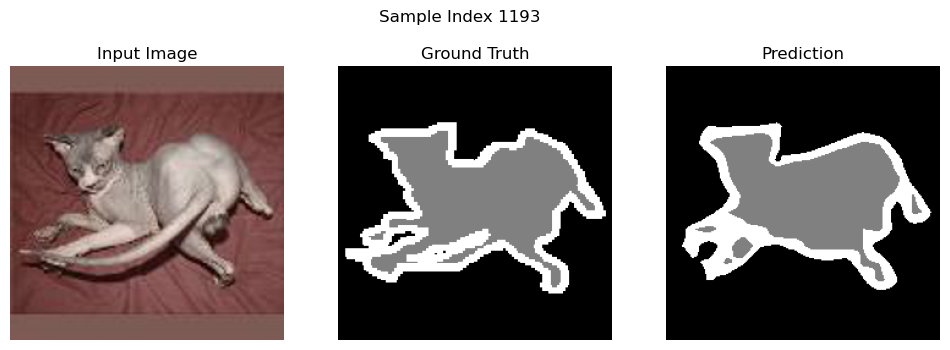

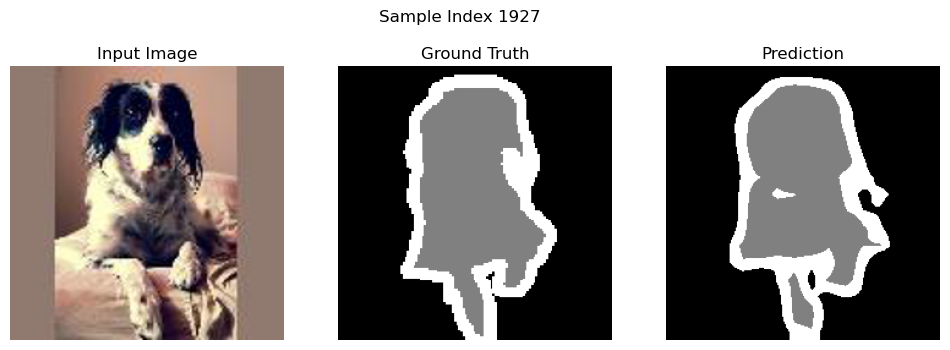

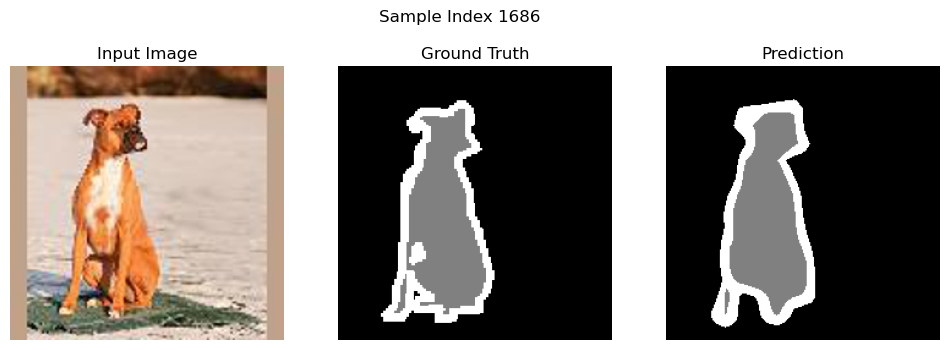

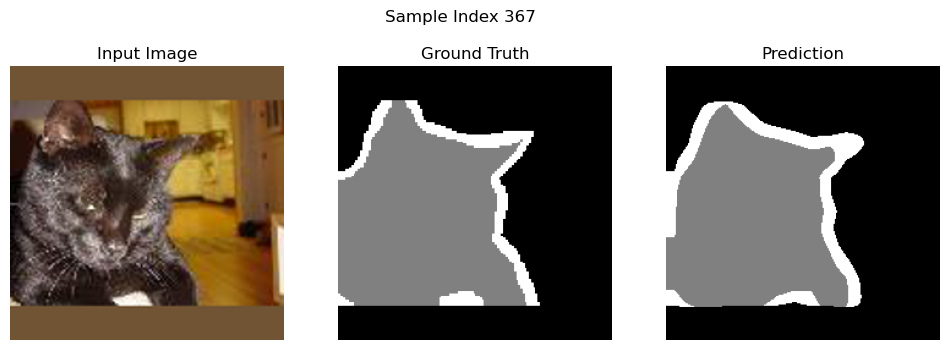

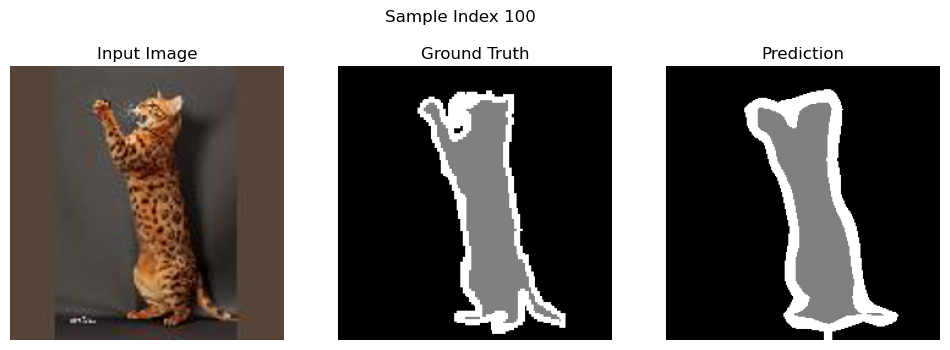

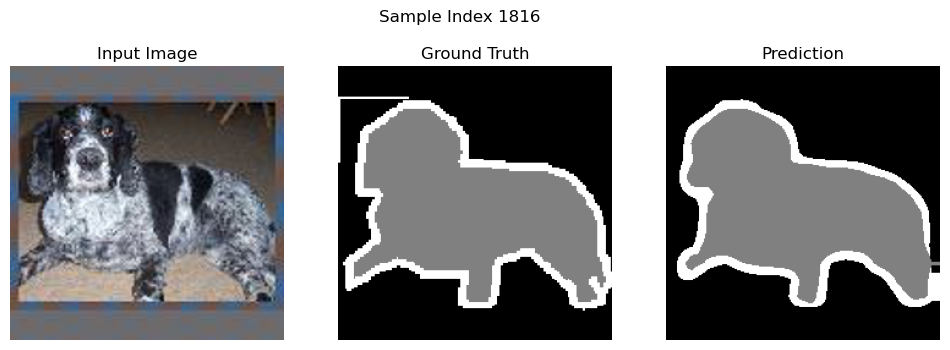

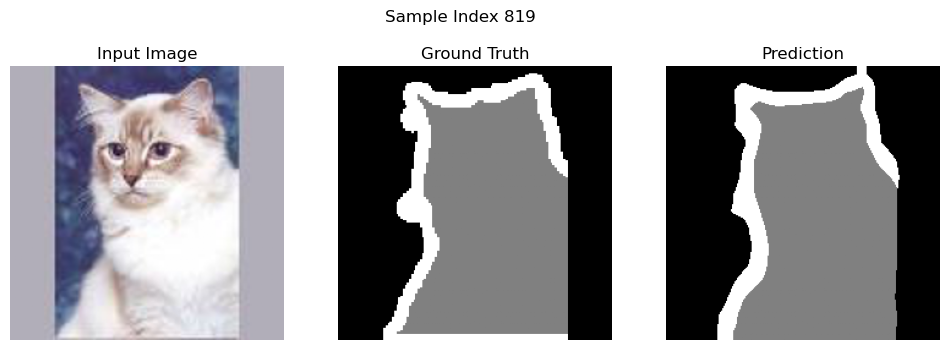

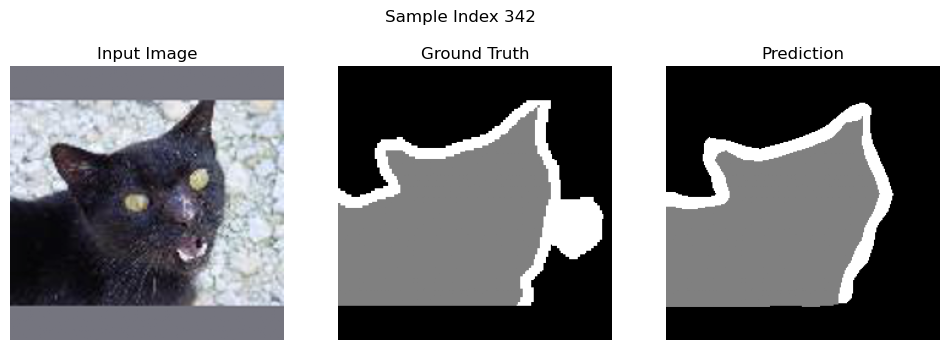

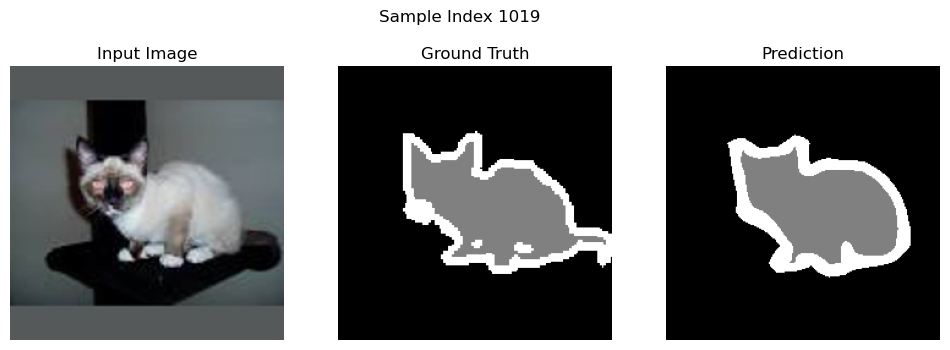

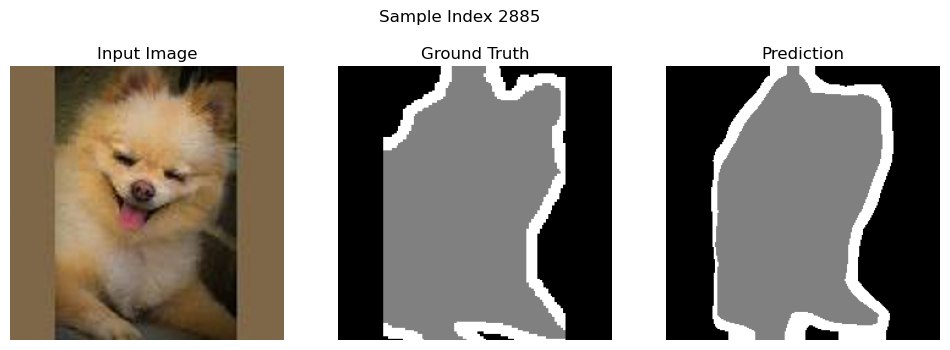

NameError: name 'test_iou' is not defined

In [1]:
###############################################
#               Testing the model             #
###############################################

import os
import clip
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import re
from typing import List
from clip.simple_tokenizer import SimpleTokenizer
import torchvision.transforms as T
from matplotlib.backends.backend_pdf import PdfPages
import random
import matplotlib.pyplot as plt

clip_tokenizer = SimpleTokenizer()

#############################################
#                Dataset Class              #
#############################################

class SegmentationDatasetWithText(Dataset):
    def __init__(self, root_dir, transform_img, transform_label=None):
        self.root_dir = root_dir
        self.transform_img = transform_img
        self.transform_label = transform_label

        # Assume images are in `root_dir/color` and masks are in `root_dir/masks`
        self.image_dir = os.path.join(root_dir, 'color')
        self.mask_dir = os.path.join(root_dir, 'label')
        
        # Collect all image filenames
        self.image_paths = sorted([
            fname for fname in os.listdir(self.image_dir)
            if fname.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_filename = self.image_paths[index]
        image_path = os.path.join(self.image_dir, image_filename)
        mask_path = os.path.join(self.mask_dir, image_filename.replace('.jpg', '.png'))
        
        # Load the image and apply image transform.
        image = Image.open(image_path).convert("RGB")
        if self.transform_img:
            image = self.transform_img(image)

        # Load the mask, convert to numpy, then to tensor.
        mask = Image.open(mask_path).convert("L")
        mask = torch.from_numpy(np.array(mask, dtype=np.int64))
        
        # If a label transform is provided, first unsqueeze to add a channel dimension.
        if self.transform_label:
            if mask.ndim == 2:  # mask shape [H, W]
                mask = mask.unsqueeze(0)  # now shape [1, H, W]
            mask = self.transform_label(mask)
            mask = mask.squeeze(0)  # back to shape [H, W]

        # Generate a text prompt.
        name, _ = os.path.splitext(image_filename)
        match = re.match(r"^(cat|dog)_([A-Za-z_]+)_(\d+)", name)
        if match:
            animal_type = match.group(1)           # 'cat' or 'dog'
            breed = match.group(2).replace("_", " ") # Replace underscores with spaces.
            # Optionally, you can title-case the breed:
            breed = breed.title()
            text_prompt = f"a photo of a {breed} {animal_type}"
        else:
            # Provide a default text prompt if the regex does not match
            print(f"Warning: Filename {image_filename} does not match expected format.")
            text_prompt = "a photo of an animal"
        
        token_ids = clip.tokenize([text_prompt]).squeeze(0)

        decoded_text = clip_tokenizer.decode(token_ids.tolist())
        #print(f"Original: {text_prompt} → Tokenized: {decoded_text}")

        return image, mask, token_ids

class EncodeMask:
    def __call__(self, mask):
        # Do not convert to float; work with the mask as is (which should be Long)
        mask = torch.where(mask < 36, torch.tensor(0, dtype=mask.dtype, device=mask.device), mask)
        mask = torch.where((mask >= 36) & (mask < 192), torch.tensor(1, dtype=mask.dtype, device=mask.device), mask)
        mask = torch.where(mask >= 192, torch.tensor(2, dtype=mask.dtype, device=mask.device), mask)
        mask = torch.clamp(mask, min=0, max=2)
        # print("Mask dtype:", mask.dtype)  # Should be torch.int64
        # print("Mask unique values:", torch.unique(mask))  # Should only contain [0, 1, 2]
        return mask  # Already Long
    
def denormalize(image_tensor):
    """Convert a normalized tensor image back to a standard (0,1) range for visualization."""
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean  # Undo normalization
    image_tensor = torch.clamp(image_tensor, 0, 1)  # Ensure values are valid
    return image_tensor

#############################################
#             Segmentation Head             #
#############################################

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class ImprovedCLIPSegmentationHead(nn.Module):
    def __init__(self, in_channels, text_dim, num_classes, dropout_prob=0.25, use_attention=True):
        super(ImprovedCLIPSegmentationHead, self).__init__()
        print(f'text_dim: {text_dim}')
        print(f'in_channels: {in_channels}')
        self.text_proj = nn.Linear(text_dim, in_channels)
        self.fuse_conv1 = nn.Sequential(
            nn.Conv2d(in_channels * 2, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob)
        )
        self.residual_block = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
        )
        self.relu = nn.ReLU(inplace=True)
        if use_attention:
            self.attention = ChannelAttention(256)
        else:
            self.attention = nn.Identity()
        self.fuse_conv2 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, img_features, text_features):
        B, C, H, W = img_features.shape  # should be [B, 768, H, W]
        
        # Ensure both inputs are float32 to avoid mismatched precision issues
        img_features = img_features.float()
        text_features = text_features.float()

        projected_text = self.text_proj(text_features)  # => [B, 768]
        projected_text = projected_text.view(B, C, 1, 1)  # => [B, 768, 1, 1]
        projected_text = projected_text.expand(B, C, H, W)  # => [B, 768, H, W]
        fused = torch.cat([img_features, projected_text], dim=1)
        x = self.fuse_conv1(fused)
        res = self.residual_block(x)
        x = self.relu(x + res)
        x = self.attention(x)
        logits = self.fuse_conv2(x)
        return logits

#############################################
#          CLIP Segmentation Model          #
#############################################

class CLIPSegmentationModel(nn.Module):
    def __init__(self, clip_model, num_classes=3):
        super(CLIPSegmentationModel, self).__init__()
        # CLIP ViT-L/14 usually outputs 768-dim features
        self.feature_dim = clip_model.visual.output_dim  # should be 768
        print(f'feature dim: {self.feature_dim}')        # prints 768

        self.clip_model = clip_model
        
        # Both in_channels and text_dim are 768
        self.seg_head = ImprovedCLIPSegmentationHead(
            in_channels=768,  # matches self.feature_dim
            text_dim=768,     # text encoder dimension
            num_classes=num_classes,
            dropout_prob=0.25
        )
    
    def get_visual_features(self, image):
        visual = self.clip_model.visual
        # Ensure input image has the same dtype as model weights (e.g., fp16)
        image = image.to(dtype=visual.conv1.weight.dtype)
        # Step 1: Convolution.
        x = visual.conv1(image)  # [B, width, H', W']
        # Flatten the spatial dimensions.
        x = x.reshape(x.shape[0], x.shape[1], -1)  # [B, width, tokens]
        x = x.permute(0, 2, 1)  # [B, tokens, width]
        # Step 2: Prepend the class token.
        cls_tokens = visual.class_embedding.to(x.dtype) + torch.zeros(
            x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device
        )
        x = torch.cat([cls_tokens, x], dim=1)  # [B, tokens+1, width]
        # Step 3: Add positional embedding.
        x = x + visual.positional_embedding.to(x.dtype)
        # Step 4: Layer norm pre-transformer.
        x = visual.ln_pre(x)
        # Step 5: Run the transformer.
        x = x.permute(1, 0, 2)  # [tokens+1, B, width]
        x = visual.transformer(x)
        x = x.permute(1, 0, 2)  # [B, tokens+1, transformer_width]
        # **Apply projection (if available) to get final visual features.**
        if hasattr(visual, "proj"):
            x = x @ visual.proj  # now x is [B, tokens+1, output_dim] (e.g. [B, tokens+1, 768])
        return x

    def forward(self, image, token_ids):
        # Convert input images to float32
        image = image.float()

        visual_features = self.get_visual_features(image)  # [B, num_tokens+1, 768]
        
        tokens = visual_features[:, 1:, :]  # remove CLS token => [B, num_tokens, 768]
        B, N, D = tokens.shape  # D should be 768
        grid_size = int(np.sqrt(N))

        image_features = tokens.reshape(B, grid_size, grid_size, 768).permute(0, 3, 1, 2)  # [B, 768, H, W]
        
        # Convert text features to float32 before passing
        text_features = self.clip_model.encode_text(token_ids).float()  # Ensure float32

        seg_logits = self.seg_head(image_features, text_features)
        
        seg_logits = F.interpolate(seg_logits, size=(image.shape[2], image.shape[3]),
                                  mode="bilinear", align_corners=False)
        return seg_logits

###############################################
# Training, Evaluation, and Utility Functions #
###############################################
def compute_iou_per_class(preds, targets, num_classes=3):
    """
    Compute Intersection over Union (IoU) for each class.
    Returns a dictionary with IoU for each class.
    """
    iou_per_class = {}
    
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            iou_per_class[cls] = float('nan')  # Avoid division by zero
        else:
            iou_per_class[cls] = intersection / union
    
    return iou_per_class

def test_best_model(best_model_path, test_dataset, batch_size=16, num_classes=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss().to(device)
    
    # Load CLIP model and set it to eval mode
    clip_model, _ = clip.load("ViT-L/14", device=device)
    clip_model.eval()
    for param in clip_model.parameters():
        param.requires_grad = False
    
    # Load segmentation model
    model = CLIPSegmentationModel(clip_model=clip_model, num_classes=num_classes).to(device)
    state_dict = torch.load(best_model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    
    # Create test DataLoader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    
    running_loss, running_correct, total_pixels = 0.0, 0, 0
    all_preds, all_masks = [], []
    
    # Evaluation loop
    with torch.no_grad():
        for images, masks, token_ids in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            token_ids = token_ids.to(device)
            
            outputs = model(images, token_ids)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
            
            preds = torch.argmax(outputs, dim=1)
            running_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)
            
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
    
    # Convert all collected predictions and ground truths to tensors
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    
    # Compute IoU per class
    iou_per_class = compute_iou_per_class(all_preds, all_masks, num_classes)
    
    # Compute test loss and accuracy
    avg_loss = running_loss / len(test_dataset)
    test_acc = running_correct / total_pixels
    mean_iou = np.nanmean(list(iou_per_class.values()))
    print(f"Test Loss: {avg_loss:.4f}, Test Acc: {test_acc:.4f}, Test IoU: {mean_iou:.4f}, IoU per class: {iou_per_class}")
    
    # Display 10 random samples from the test set
    import random
    import matplotlib.pyplot as plt
    
    indices = random.sample(range(len(test_dataset)), 10)
    for idx in indices:
        image, mask, token_ids = test_dataset[idx]
        # Send to device and add batch dimension
        image_tensor = image.unsqueeze(0).to(device)
        token_ids = token_ids.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor, token_ids)
            pred = torch.argmax(output, dim=1).squeeze().cpu()
        
        # Denormalize the image for visualization (using your denormalize function)
        image_denorm = denormalize(image.cpu())
        image_np = image_denorm.permute(1, 2, 0).numpy()
        mask_np = mask.cpu().numpy()
        pred_np = pred.numpy()
        
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(image_np)
        axs[0].set_title("Input Image")
        axs[1].imshow(mask_np, cmap='gray', vmin=0, vmax=num_classes-1)
        axs[1].set_title("Ground Truth")
        axs[2].imshow(pred_np, cmap='gray', vmin=0, vmax=num_classes-1)
        axs[2].set_title("Prediction")
        for ax in axs:
            ax.axis('off')
        fig.suptitle(f"Sample Index {idx}")
        plt.savefig(f"CLIP_Test_{idx}.pdf", format="pdf", bbox_inches="tight")
        plt.show()
    
    return avg_loss, test_acc, test_iou

# Example usage:
if __name__ == "__main__":
    # Load CLIP preprocessing transform
    clip_model, clip_preprocess = clip.load("ViT-L/14", device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    test_transform = clip_preprocess  # Use the same image preprocessing as for training

    # Define a label transform that resizes the mask and encodes its values properly.
    transform_label = T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.NEAREST),
        EncodeMask()
    ])

    test_dataset = SegmentationDatasetWithText(
        root_dir="./Dataset/processed/Test/",
        transform_img=test_transform,
        transform_label=transform_label
    )
    
    best_model_path = "clip_OPENAI_segmentation_best.pth" 
    test_loss, test_acc, test_iou = test_best_model(best_model_path, test_dataset, batch_size=16, num_classes=3)